In [1]:
!pip install scikit-learn glob2 tqdm pesq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 32.6 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 36.3 MB/s eta 0:00:00
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9301 sha256=e0ee7c0d6b475b5e115cc725a6a4100ae5b062c392ce08122119b4c07ac162e9
  Stored in directory: /root/.cache/pip/wheels/95/59/ed/52469ecfae47a78c25f11bcb49db42ff84629df01861876883
  Created wheel for pesq: filename=pesq-0.0.4-cp38-cp38-linux_x86_64.whl size=303803 sha256=383f190dfe11d07429d5b1240a43ea00c3153f2d4b7c8cbab7307cb8e5adc818
  Stored in directory: /root/.cache/pip/wheels/be/50/3f/1e20ce10f2e57d3481b488245b0f05f013602dd6dca0a67d18
Successfully built glob2 pesq

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgr

In [2]:
import numpy as np
import os
# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten, UpSampling1D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape

# import sounddevice as sd
from scipy.signal import butter, filtfilt
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm
from pesq import pesq
import matplotlib.pyplot as plt


from utils import load_wav, generate_white_gaussian_noise, add_white_gaussian_noise, undersample_signal_with_antialiasing, somar_sinais, calculate_snr

# Descrição do Código

O código apresenta uma função chamada `get_sounds_from_folder` que recebe um caminho de diretório e um padrão como entrada e retorna uma lista de arquivos de som que correspondem ao padrão dentro do diretório e de seus subdiretórios até uma profundidade máxima especificada.

Em seguida, o código define uma série de operações para carregar arquivos de som, processá-los e prepará-los para treinamento. Ele carrega arquivos de ruído e sons limpos, realiza uma série de transformações nesses sons (como subamostragem e remodelagem), e os armazena em listas.

Após isso, o código realiza algumas operações de pré-processamento nos dados, como normalização e ajuste de limites, e exibe informações sobre a forma (shape) e os valores máximo e mínimo dos sons limpos e dos ruídos.

Em seguida, é definida uma classe chamada `DataGenerator`, que contém três métodos: `generate_sample_pesq`, `generate_sample_completo` e `generate_sample_pre`. Esses métodos geram lotes de exemplos de treinamento a partir dos arquivos de som e ruído carregados anteriormente. Cada lote contém um conjunto de sons e ruídos, aos quais são aplicadas diversas transformações e cálculos, como adição de ruído, cálculo da nota PESQ e formatação dos dados para treinamento. Os lotes são retornados em forma de geradores para serem utilizados no treinamento de um modelo.

No geral, o código carrega sons e ruídos, realiza transformações nos dados e os prepara para treinamento, além de fornecer métodos para gerar lotes de exemplos de treinamento com diferentes configurações.

In [2]:
def get_sounds_from_folder(path, pattern):
    max_depth = 3  # replace with the maximum depth of subfolders to search

    sound_list = []

    for root, dirs, files in os.walk(path):
        depth = root[len(path) + len(os.path.sep):].count(os.path.sep)
        if depth < max_depth:
            for file in files:
                if file.endswith(pattern):#or file.endswith('.bin'):
                    wav_path = os.path.join(root, file)
                    sound_list.append(wav_path)
    
    return sound_list

In [3]:
base_shape_size = 6144

In [4]:
noise_files_dir = './ESC-50-master/audio/'

In [5]:
noise_files = os.listdir(noise_files_dir)

In [6]:
# Load noisy sounds

noise_sounds = []

for noise_file in tqdm(noise_files):
    noise_sound = load_wav(os.path.join(noise_files_dir, noise_file))
    noise_sound_under = undersample_signal_with_antialiasing(noise_sound, 44100, 8000)
    noise_sound_under = noise_sound_under[base_shape_size:base_shape_size*3]
    noise_sound_under = noise_sound_under.reshape(-1, base_shape_size)
    noise_sounds.append(noise_sound_under)

noise_sounds = np.array(noise_sounds).reshape(-1, base_shape_size)

100%|█| 2000/2000 [00:39<00:00, 50.45it


In [7]:
clean_files = get_sounds_from_folder('./Base', 'clean.wav')

In [8]:
# Load clean sounds

clean_sounds = np.empty((1, base_shape_size), np.float32)

for clean_file in tqdm(clean_files):
    clean_sound = load_wav(clean_file)
    clean_sound = clean_sound[:len(clean_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)
    clean_sounds = np.append(clean_sounds, clean_sound, axis=0)

# clean_sounds = np.array(clean_sounds).reshape(-1, base_shape_size)

100%|█| 5476/5476 [01:53<00:00, 48.35it


In [9]:
clean_sounds = np.nan_to_num(clean_sounds, nan=0.0)
noise_sounds = np.nan_to_num(noise_sounds, nan=0.0)

In [10]:
clean_sounds = np.clip(clean_sounds, -1., 1.)
noise_sounds = np.clip(noise_sounds, -1., 1.)

In [11]:
print(clean_sounds.shape)
print(noise_sounds.shape)

(11313, 6144)
(4000, 6144)


In [12]:
print(np.max(clean_sounds))
print(np.max(noise_sounds))

1.0
1.0


In [13]:
print(np.min(clean_sounds))
print(np.min(noise_sounds))

-1.0
-1.0


In [14]:
train_split = 0.6
val_split = 0.2
test_split = 0.2

In [15]:
train_X = clean_sounds[:int(len(clean_sounds)*train_split)]
val_X = clean_sounds[int(len(clean_sounds)*train_split):int(len(clean_sounds)*(train_split + val_split))]
test_X = clean_sounds[int(len(clean_sounds)*(train_split + val_split)):]

In [16]:
train_X.shape

(6787, 6144)

In [17]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files
        
    def normalize_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        normalized_array = (array - min_val) / (max_val - min_val)
        normalized_array = normalized_array * 2 - 1
        return normalized_array

    def generate_sample_pesq(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(-5, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound, noisy_sound, 'nb')
                except:
                    continue

                valor_min = -0.6
                valor_max = 4.6
                pesq_score = (pesq_score - valor_min) / (valor_max - valor_min)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((base_shape_size, 1))
                
                merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(merged_array)
                y_train.append(pesq_score)
            
            yield np.array(x_train), np.array(y_train)
            
    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            x2_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(-5, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                pesq_score = 1.0
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((256, 24, 1))
                
#                 merged_array = np.concatenate((original_sound, d_sound), axis=1)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                x2_train.append(original_sound)
                y_train.append(pesq_score)
            
            yield [np.array(x1_train), np.array(x2_train)], np.array(y_train)

    def generate_sample_pre(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                sr = np.random.randint(-5, 60, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
                noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 30, size=(1,)[0]))
                noisy_sound = self.normalize_array(noisy_sound)
                
                # Formata dados para treinamento
                original_sound = sound.reshape((base_shape_size, 1))
                d_sound = noisy_sound.reshape((256, 24, 1))
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                y_train.append(original_sound)
            
            yield np.array(x1_train), np.array(y_train)

In [18]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

## Modelo para a PESQ

1. Uma função `cnn()` é definida para construir a arquitetura do modelo CNN.
2. O modelo é criado chamando `cnn()`, e um resumo do modelo é impresso.
3. Instâncias de `DataGenerator` são criadas para os dados de treinamento e validação.
4. O modelo é compilado com o otimizador 'adam' e a função de perda 'mse' (erro quadrático médio).
5. Parâmetros de treinamento são definidos, como tamanho do lote e etapas por época.
6. O treinamento começa com um loop que itera três vezes para três épocas.
7. Para cada época, um novo lote de validação é gerado usando o gerador de dados de validação.
8. O modelo é treinado usando o gerador de dados de treinamento, com as etapas por época, épocas, dados de validação e um callback para visualização de perda.
9. Após o treinamento, o modelo é salvo em um arquivo chamado 'pesq-generator-16.h5'.

In [152]:
def cnn():
    # Define the input shape
    input_shape = (base_shape_size, 2)

    # Define the model architecture
    input_layer = Input(shape=input_shape)

    conv1 = Conv1D(16, 17, activation='tanh')(input_layer)
    conv1 = Conv1D(16, 17, activation='tanh')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(32, 9, activation='tanh')(pool1)
    conv2 = Conv1D(32, 9, activation='tanh')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = Conv1D(64, 3, activation='tanh')(pool2)
    conv3 = Conv1D(64, 3, activation='tanh')(conv3)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    flatten = Flatten()(pool2)
    dense1 = Dense(64, activation='tanh')(flatten)
    dense1 = Dense(64, activation='tanh')(dense1)
    output_layer = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [153]:
model = cnn()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 6144, 2)]         0         
                                                                 
 conv1d_12 (Conv1D)          (None, 6128, 16)          560       
                                                                 
 conv1d_13 (Conv1D)          (None, 6112, 16)          4368      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 3056, 16)         0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 3048, 32)          4640      
                                                                 
 conv1d_15 (Conv1D)          (None, 3040, 32)          9248      
                                                          

In [154]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(train_X, noise_sounds)
data_generator_val = DataGenerator(val_X, noise_sounds)

Starting training
Epoch 1
212/212 [==============================] - 55s 251ms/step - loss: 0.0023 - val_loss: 6.6752e-04
Epoch 2
212/212 [==============================] - 53s 253ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 3
212/212 [==============================] - 53s 250ms/step - loss: 0.0023 - val_loss: 0.0034


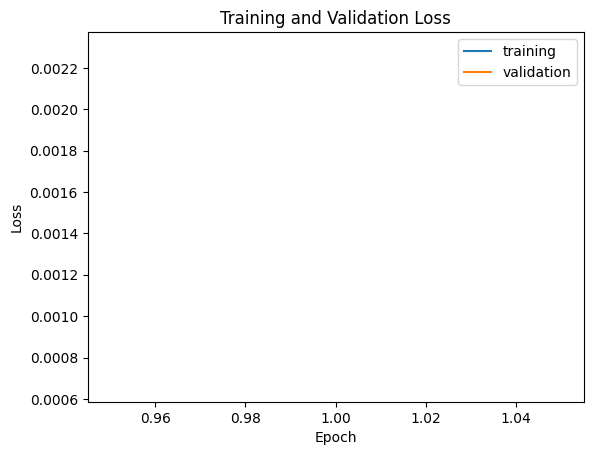

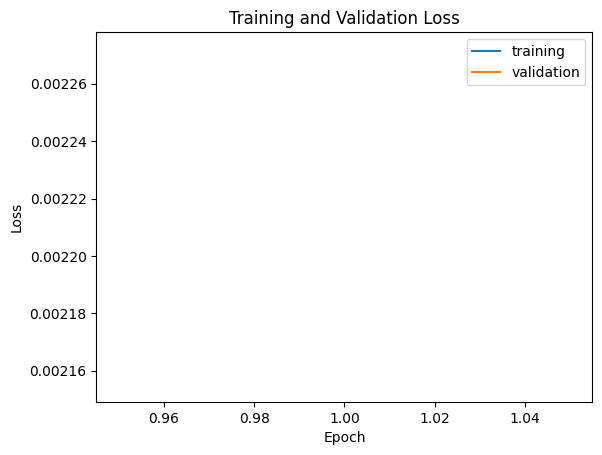

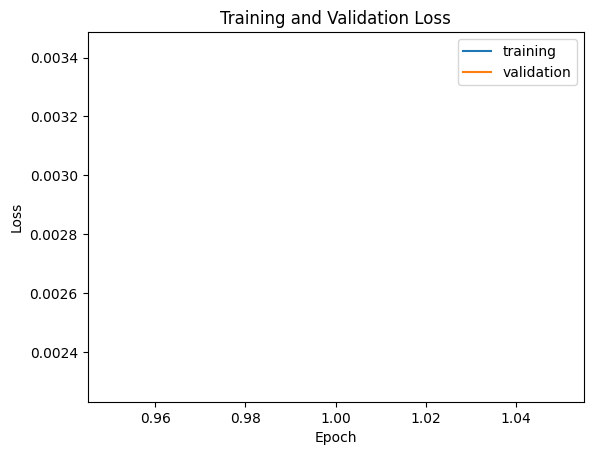

In [156]:
model.compile(optimizer='adam', loss='mse',)

batch_size = 32
steps_per_epoch = len(train_X) // batch_size

print('Starting training')

for epoch in range(3):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_pesq(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    model.fit(data_generator_train.generate_sample_pesq(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
              callbacks=[PlotLossesCallback()]
             )

# score = model.evaluate(X_test, y_test, verbose=0)
# print(score)
model.save('pesq-generator-16.h5')

## Pré treinamento da rede para remoção de ruído

Nesta etapa, estamos utilizando a arquitetura UNet de redes neurais para
montar um modelo para a remoção de ruído

In [19]:
def unet(inputs):

    # Encoder
    conv1 = Conv2D(64, 3, activation='tanh', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='tanh', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Middle
    conv3 = Conv2D(256, 3, activation='tanh', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='tanh', padding='same')(conv3)
    
    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Conv2D(128, 3, activation='tanh', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=3)
    conv4 = Conv2D(128, 3, activation='tanh', padding='same')(merge1)
    conv4 = Conv2D(128, 3, activation='tanh', padding='same')(conv4)
    
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Conv2D(64, 3, activation='tanh', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=3)
    conv5 = Conv2D(64, 3, activation='tanh', padding='same')(merge2)
    conv5 = Conv2D(64, 3, activation='tanh', padding='same')(conv5)
    
    # Output
    output = Conv2D(1, 1, activation='tanh')(conv5)
    output = Reshape((base_shape_size, 1))(output)

    return output

In [61]:
def big_unet(inputs):
    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(256, 2, strides=(2, 3), padding='same')(drop5)
    attn4 = MultiHeadAttention(num_heads=2, key_dim=16)(conv4, conv4)
    merge6 = concatenate([attn4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv6)
    attn3 = MultiHeadAttention(num_heads=2, key_dim=16)(conv3, conv3)
    merge7 = concatenate([attn3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7)
#     attn2 = MultiHeadAttention(num_heads=2, key_dim=16)(conv2, conv2)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8)
#     attn1 = MultiHeadAttention(num_heads=2, key_dim=16)(conv1, conv1)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='tanh')(conv9)
    output = Reshape((base_shape_size, 1))(conv10)
    
    return output

In [62]:
input_pre = Input(shape=(256, 24, 1))
output_pre = big_unet(input_pre)

modelo_pre = Model(inputs=input_pre, outputs=output_pre)

In [63]:
modelo_pre.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 24, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_143 (Conv2D)            (None, 256, 24, 32)  320         ['input_9[0][0]']                
                                                                                                  
 conv2d_144 (Conv2D)            (None, 256, 24, 32)  9248        ['conv2d_143[0][0]']             
                                                                                                  
 max_pooling2d_32 (MaxPooling2D  (None, 128, 12, 32)  0          ['conv2d_144[0][0]']       

                                                                                                  
 conv2d_159 (Conv2D)            (None, 256, 24, 32)  18464       ['concatenate_32[0][0]']         
                                                                                                  
 conv2d_160 (Conv2D)            (None, 256, 24, 32)  9248        ['conv2d_159[0][0]']             
                                                                                                  
 conv2d_161 (Conv2D)            (None, 256, 24, 1)   33          ['conv2d_160[0][0]']             
                                                                                                  
 reshape_7 (Reshape)            (None, 6144, 1)      0           ['conv2d_161[0][0]']             
                                                                                                  
Total params: 7,809,249
Trainable params: 7,809,249
Non-trainable params: 0
_________________________________

In [64]:
# Crie uma instância do DataGenerator
data_generator_train_pre = DataGenerator(train_X, noise_sounds)
data_generator_val_pre = DataGenerator(val_X, noise_sounds)

In [66]:
modelo_pre.compile(optimizer='adam', loss='mse',)

batch_size = 16
steps_per_epoch = len(train_X) // batch_size

print('Starting training')

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val_pre.generate_sample_pre(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    modelo_pre.fit(data_generator_train_pre.generate_sample_pre(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
             )


Starting training
Epoch 1


2023-05-20 17:54:21.710237: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_7/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


424/424 [==============================] - 26s 44ms/step - loss: 0.0244 - val_loss: 0.0238
Epoch 2
424/424 [==============================] - 19s 45ms/step - loss: 0.0246 - val_loss: 0.0256
Epoch 3
424/424 [==============================] - 19s 46ms/step - loss: 0.0248 - val_loss: 0.0225
Epoch 4
424/424 [==============================] - 19s 46ms/step - loss: 0.0250 - val_loss: 0.0209
Epoch 5
424/424 [==============================] - 19s 44ms/step - loss: 0.0247 - val_loss: 0.0190
Epoch 6
424/424 [==============================] - 19s 44ms/step - loss: 0.0242 - val_loss: 0.0275
Epoch 7
424/424 [==============================] - 19s 44ms/step - loss: 0.0241 - val_loss: 0.0182
Epoch 8
424/424 [==============================] - 20s 46ms/step - loss: 0.0244 - val_loss: 0.0264
Epoch 9
424/424 [==============================] - 19s 45ms/step - loss: 0.0241 - val_loss: 0.0230
Epoch 10
424/424 [==============================] - 19s 46ms/step - loss: 0.0241 - val_loss: 0.0365


In [164]:
modelo_pre.save('modelo-pre.h5')

In [67]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
sound = sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

noisy_sound = load_wav('./Base/BR_00400/balsen3_2_1.wav')
noisy_sound = noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

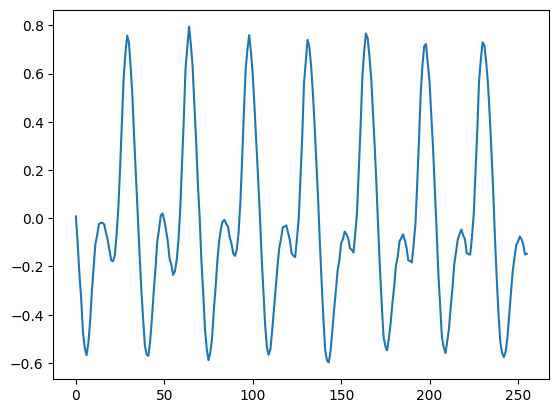

In [68]:
plt.plot(sound[0][1000:1256])

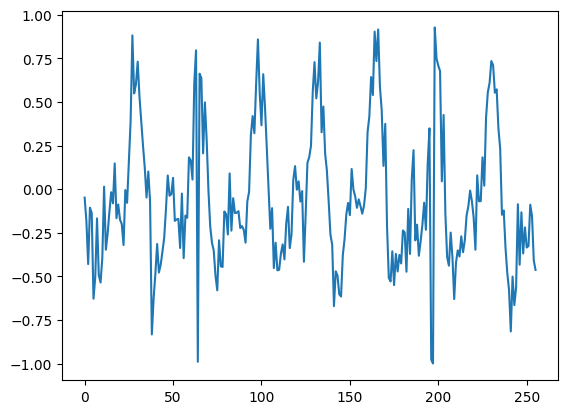

In [69]:
plt.plot(noisy_sound[0][1000:1256])

In [70]:
noisy_sound = noisy_sound.reshape(-1, 256, 24, 1)

In [71]:
filtered = modelo_pre.predict(noisy_sound)

1/1 [==============================] - 1s 633ms/step


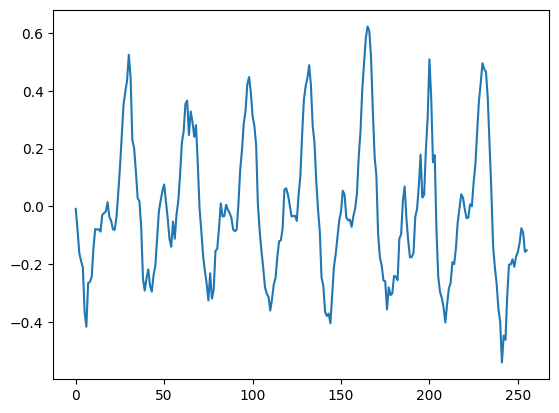

In [72]:
plt.plot(filtered[0][1000:1256])

In [171]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound, noisy_sound)))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound, filtered)))

SNR sinal ruidoso: 2.1780332922935486
SNR sinal filtrado: 1.8356099724769592


In [172]:
# Carregar o modelo treinado
modelo_treinado = load_model('pesq-generator-16.h5')

# Definir seus pesos como não treináveis
for layer in modelo_treinado.layers:
    layer.trainable = False

In [173]:
modelo_pre = load_model('modelo-pre.h5')

In [174]:
input_novo = Input(shape=(256, 24, 1))
input_concat = Input(shape=(base_shape_size, 1))

output_novo = modelo_pre(input_novo)
output_concat = concatenate([output_novo, input_concat], axis=-1)

completo = modelo_treinado(output_concat)

modelo_final = Model(inputs=[input_novo, input_concat], outputs=completo)

In [175]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(train_X, noise_sounds)
data_generator_val = DataGenerator(val_X, noise_sounds)

In [176]:
modelo_final.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 256, 24, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_14 (Functional)          (None, 6144, 1)      2066497     ['input_26[0][0]']               
                                                                                                  
 input_27 (InputLayer)          [(None, 6144, 1)]    0           []                               
                                                                                                  
 concatenate_10 (Concatenate)   (None, 6144, 2)      0           ['model_14[0][0]',        

In [177]:
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
x_val, y_val = validation_batch

In [178]:
x_val[0].shape

(64, 256, 24, 1)

Starting training
Epoch 1
106/106 [==============================] - 24s 218ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 2
106/106 [==============================] - 23s 217ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 3
106/106 [==============================] - 23s 217ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 4
106/106 [==============================] - 23s 217ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 5
106/106 [==============================] - 23s 217ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 6
106/106 [==============================] - 23s 218ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 7
106/106 [==============================] - 23s 218ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 8
106/106 [==============================] - 23s 218ms/step - loss: 0.4074 - val_loss: 0.4074 - lr: 1.0000e-04
Epoch 9
106/106 [=============================

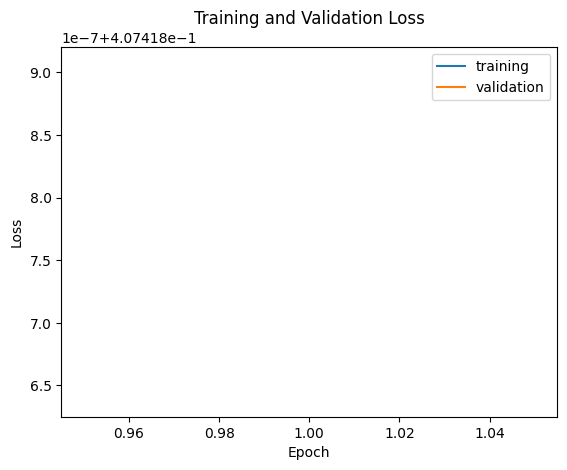

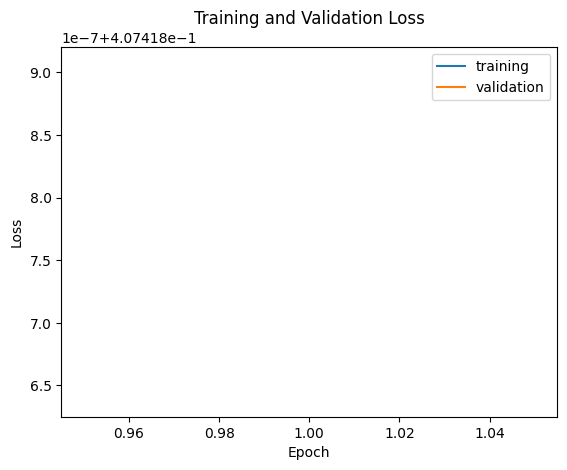

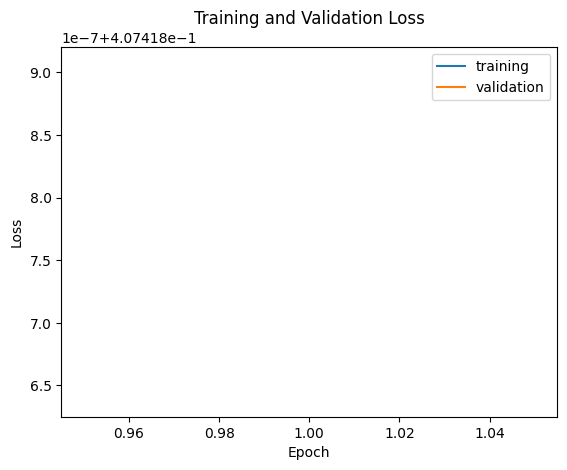

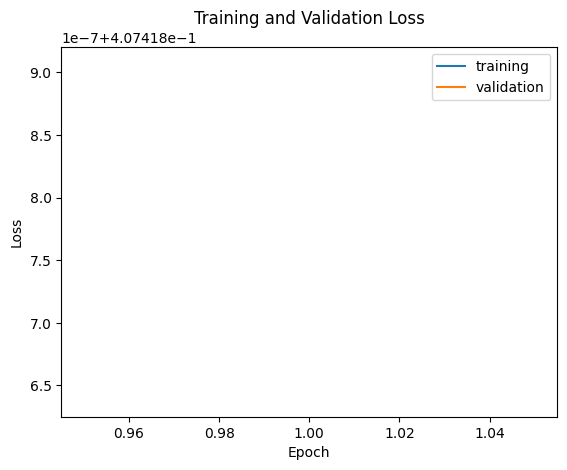

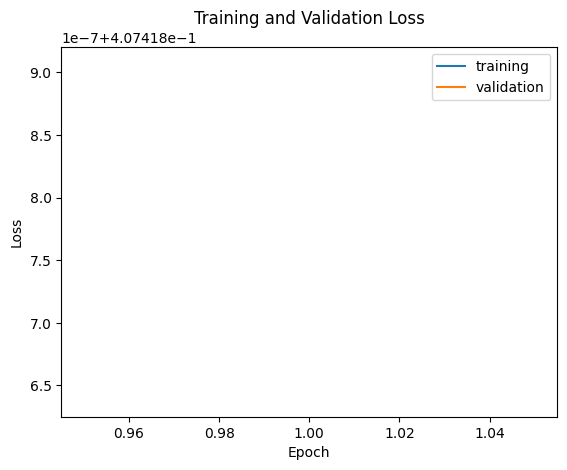

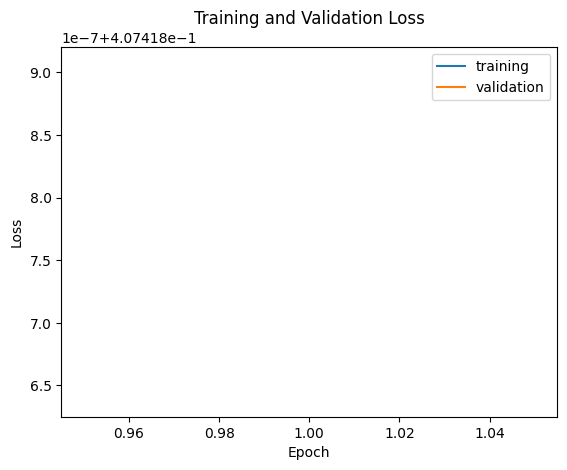

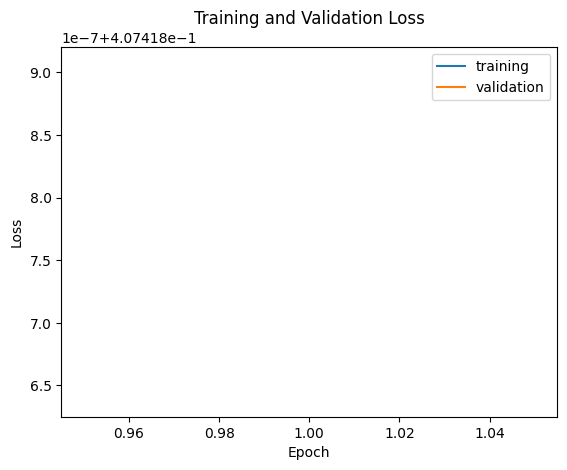

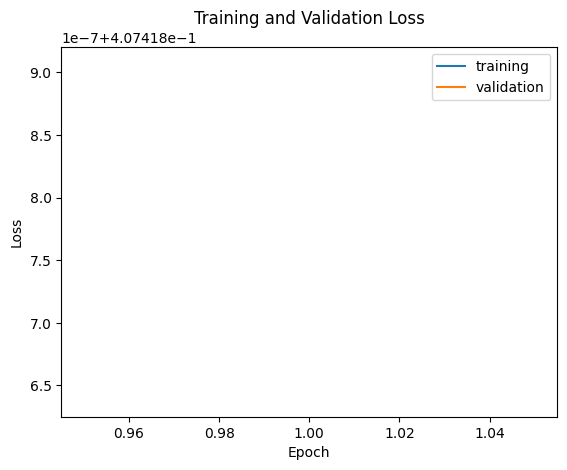

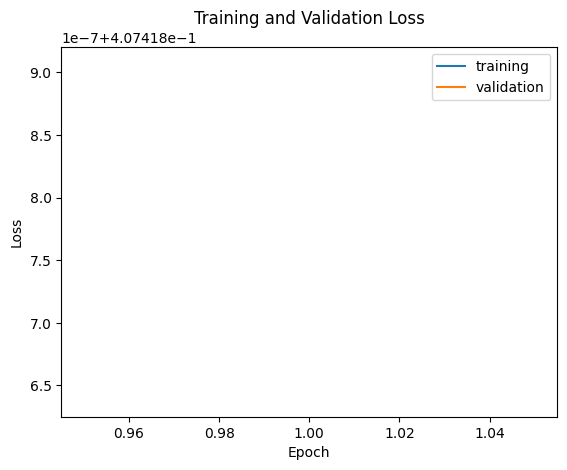

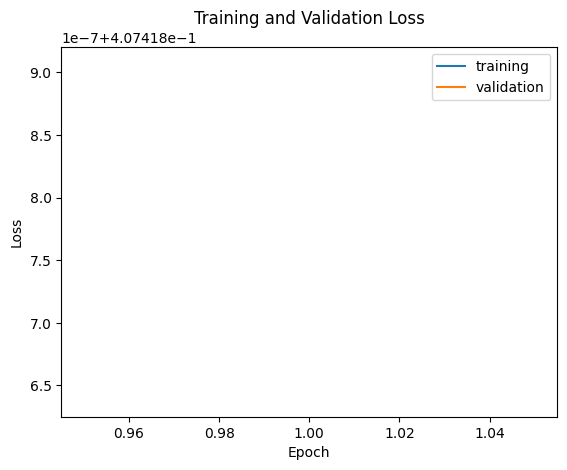

In [179]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2

# Definir taxa de aprendizado e fator de decaimento
learning_rate = 0.0001
decay_factor = 0.1

# Definir taxa de aprendizado para as camadas adicionais
additional_layers_lr = 0.001

# Definir regularização L2
l2_regularization = 0.01

# Compilar o modelo final com os ajustes
optimizer = Adam(learning_rate=learning_rate)
modelo_final.compile(optimizer=optimizer, loss='mse')

# Ajustar a taxa de aprendizado das camadas adicionais
for layer in modelo_final.layers:
    if layer.name.startswith('camadas_adicionais'):
        layer.learning_rate = additional_layers_lr

# Definir tamanho do lote e número de passos por época
batch_size = 64
steps_per_epoch = len(train_X) // batch_size

# Definir decaimento da taxa de aprendizado
lr_decay = ReduceLROnPlateau(factor=decay_factor)

print('Starting training')

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    modelo_final.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
                     callbacks=[PlotLossesCallback(), lr_decay]
                    )

In [180]:
inferencia_modelo_novo = Model(inputs=input_novo, outputs=output_novo)
inferencia_modelo_novo.save('modelo-sem-PESQ-16.h5')

In [181]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
sound = sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

noisy_sound = load_wav('./Base/BR_00400/balsen3_2_1.wav')
noisy_sound = noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size, 1)

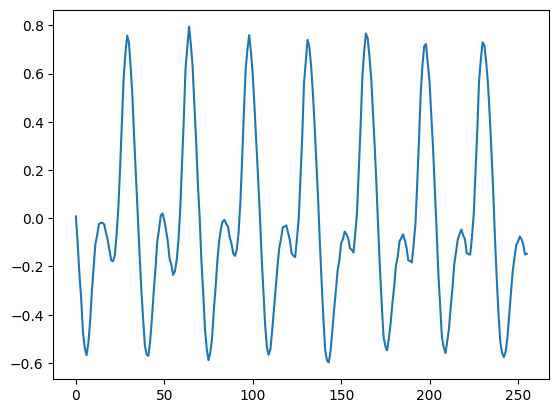

In [182]:
plt.plot(sound[0][1000:1256])

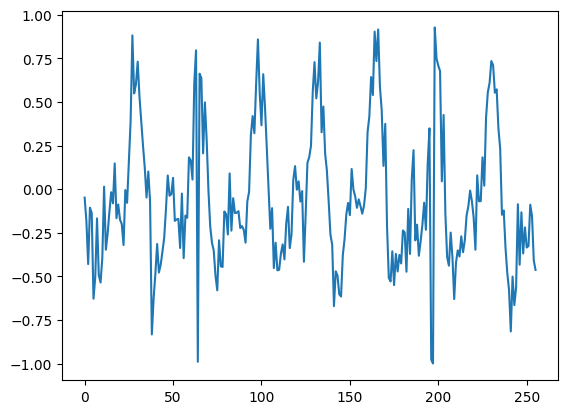

In [183]:
plt.plot(noisy_sound[0][1000:1256])

In [184]:
noisy_sound.shape

(5, 6144, 1)

In [185]:
filtered = inferencia_modelo_novo.predict(noisy_sound.reshape(-1, 256, 24, 1))

1/1 [==============================] - 0s 101ms/step


In [186]:
filtered.shape

(5, 6144, 1)

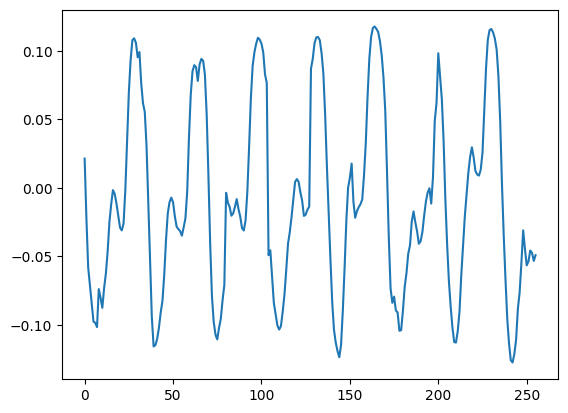

In [187]:
filtered_sound = filtered.reshape(-1, 1)
plt.plot(filtered_sound[1000:1256])

In [188]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(sound, noisy_sound)))
print('SNR sinal filtrado: {}'.format(calculate_snr(sound, filtered)))

SNR sinal ruidoso: 2.1780332922935486
SNR sinal filtrado: 1.8349383771419525


In [115]:
sound.reshape(-1).shape

(30720,)

In [116]:
pesq(8000, sound[0].reshape(-1), filtered[0].reshape(-1), 'nb')

1.0310816764831543

In [117]:
np.concatenate((sound[0], filtered[0]), axis=1).reshape(1, 6144,2).shape

(1, 6144, 2)

In [118]:
pesq_net_score = modelo_treinado.predict(np.concatenate((sound[0], filtered[0]), axis=1).reshape(1, 6144,2))

1/1 [==============================] - 0s 14ms/step


In [119]:
pesq_net_score * (4.6 +0.6) - 0.6

array([[1.0835648]], dtype=float32)